# GIST postprocessing using gisttools

## Installation of required packages 
A number of python packages are necessary to run this tutorial. Besides the prerequisites to run [gisttools](https://github.com/liedllab/gisttools), the following packages are needed:
* [matplotlib](https://matplotlib.org/) 
* [nglview](https://github.com/nglviewer/nglview)
* [scikit-image](https://scikit-image.org)
* [ipyvolume](https://github.com/maartenbreddels/ipyvolume)

## Loading files

In [1]:
import gisttools as gt
import numpy as np
import pandas as pd
import mdtraj as md
import matplotlib.pyplot as plt

%matplotlib inline

**How to load a GIST output file**
* If we don't set n_frames and rho0, they will be autodetected. n_frames is the number of frames that were used in the GIST calculation, and rho0 is the reference density. rho0 should match the value set in the GIST input file.
* I recommend to use the autodetection and then check whether the results are correct, since this may also help to detect errors in the file format etc.
* If we want our energy values to be referenced to bulk, we need to set eww_ref correctly. This can also be done later, since the reference value is applied dynamically. See below for more information.
* The reference structure *struct* provides the default coordinates ("*centers*") for the analysis functions. It should be oriented exactly the same way as the solute during the GIST calculation. If you don't want the hydrogen atoms to be included in your analyses, you may specify *strip_H=True* to remove them.

In [2]:
gistfile = gt.gist.load_gist_file('out.dat.gz', struct='benzene.pdb', eww_ref=-9.539)
print(f'n_frames = {gistfile.n_frames}, rho0 = {gistfile.rho0}')

n_frames = 10000, rho0 = 0.03289974737578259


**How to obtain a value for eww_ref**
* The correct value for `eww_ref` depends on the water model and the simulation conditions, especially on the temperature. There is also a small dependence on the box size, so if you can, you should use a reference value that was calculated from a simulation box with roughly the correct size.
* There are 2 ways of calculating reference values: from a reference simulation of pure water (manually), or from bulk-like (i.e., far away from the solute) regions of your GIST calculation box (using `detect_reference_value`).
* To calculate a reference energy manually from a pure water simulation, you should perform a GIST calculation and then use:

    $E_{ww}^{ref} = V_{voxel} N_{frames} \frac{\sum{E_{ww, unref}^{dens}}}{\sum{population}}$
* `detect_reference_value` automatically calculates reference values, e.g. for `Eww_unref`. It only uses the values at a certain distance from the solute, assuming that there is no disturbance of the water properties any more. `detect_reference_value` performs some simple sanity checks (via the parameters `max_spread`, `min_relative_population`, and `n_bins`). Nevertheless, manual convergence checks should be done.

* Unless a modern version of GIGIST is used (which has more nearest neighbor search, and better volume calculation for the NN entropy), the bulk S(six) and S(orient) values don't converge exactly to zero. When integrating over very large regions of the box, this can sum up to a high value. In that case, you might also want to reference the entropy. Currently, there is no `dtssix_ref` implemented, but the referencing can be done manually by subtracting from the `_norm` column and then computing the `_dens` column using the `norm2dens` method.

In [3]:
# This is how to get a reference value manually from a pure-water simulation.
# This yields a wrong value in this case, becasue the GIST calculation contains a solute!
pure_water_ref = gistfile['Eww_unref_dens'].sum() * gistfile.grid.voxel_volume * gistfile.n_frames / gistfile['population'].sum()
print(f'Reference value calculated using the method for a pure-water simulation:\nEww_ref = {pure_water_ref}')

Reference value calculated using the method for a pure-water simulation:
Eww_ref = -9.534611937412624


In [4]:
# If there is a solute present (like in this case), this method should be used instead.
# This does not set the reference values, it only returns them.
print('Reference values calculated from the bulk water of a simulation containing a solute:')
refvals = gistfile.detect_reference_value(['Eww_unref', 'dTSsix'], dlim=(16, 22))
refvals

Reference values calculated from the bulk water of a simulation containing a solute:


Eww_unref   -9.539297
dTSsix       0.007744
dtype: float64

## Accessing data

### Column access

GIST columns can be accessed via `__getitem__`, e.g., `gist['Eww_dens']`.

**"Recipes" / dynamically calculated data columns**

There are several automatically calculated data columns that can be used in Gist objects. They are calculated on-demand and can be used like a normal column in the analyses or via `__getitem__`. Note that access to these columns is of course slower, so if you need to access them very often, consider saving them into a local Series (or ndarray). Setting these columns (`gist['A_norm'] = gist['A_norm']`) turns them into "normal" columns, and prevents automatic updating in the future!

An explanation of the different values can be found e.g. in: Kraml J, Kamenik AS, Waibl F, Schauperl M, Liedl KR. Solvation Free Energy as a Measure of Hydrophobicity: Application to Serine Protease Binding Interfaces. J Chem Theory Comput. 2019;15(11):5872-5882. doi:10.1021/acs.jctc.9b00742

Also, please consult the Amber manual for a detailed description of the computed values.

* The free energy `A_norm` is calculated from `Eww_norm`, `Esw_norm`, and `dTSsix_norm`.
* A sum of the energy contributions `E_all_norm` is calculated from `Eww_norm` and `Esw_norm`.
* If `dTSsix_norm` is not available, it is calculated from `dTStrans_norm` and `dTSorient_norm`. Note that this is strictly speaking not exactly the same as the "real" dTSsix.
* The respective `_dens` columns are calculated from their `norm` counterparts. The same functionality can be used manually via the `dens2norm` method.

**Specifying data columns in the analysis methods**

The analysis methods (e.g. `projection_mean`, `projection_nearest`, `detect_reference_value`, `integrate_around`) are defined such that they either require solely `_dens` or `_norm` columns. Therefore, they append the correct suffix automatically. This means that you should specify columns *without* the suffix, e.g. `projection_mean(['A', 'dTSsix'], ...`). To suppress this behaviour, specify `col_suffix=""` (an empty string).

In [5]:
gistfile['A_dens'].head()

0    0.003220
1    0.008456
2    0.014216
3    0.005524
4   -0.001372
dtype: float64

### Row / voxel access

To select a subset of the voxels at the same time, use the `.loc` accessor, which works similar to `pandas` (but not exactly the same...).

**Accessing voxels**

Since Gist objects internally use a DataFrame with a single index to store their data, one needs flat (unravelled) indices to access individual voxels.
* Ranges can be used to access voxels. Note that the returned range includes the stop element! This is consistent with the behaviour of `pandas`, but different to `numpy`.
* More commonly, you might want to use lists or arrays of indices to access an array of voxels.
* If you want numpy-like indexing behaviour, feel free to extract the values of a data column. This also allows you to index the x, y and z directions simultaneously.

In [6]:
# pandas-like row indexing
gistfile.loc[2:5, 'A_dens']

2    0.014216
3    0.005524
4   -0.001372
5   -0.011889
dtype: float64

In [7]:
# transform to an array to get numpy-like indexing capabilities
arr = gistfile['A_dens'].values
arr.reshape(gistfile.grid.shape)[0:2, 0:2, 0:2]

array([[[ 0.00322043,  0.00845606],
        [-0.00703211,  0.00150487]],

       [[ 0.00844816, -0.00383255],
        [-0.00979198, -0.00491971]]])

**Choosing voxels**

The Grid class contains functionality to deal with geometric voxel selection and conversion to flat (unravelled) voxels.

In [8]:
# select the closest voxel to a certain point
position = [3.0, 4.3, 4.5]
print(f'Closest voxel to position {position}: ', gistfile.grid.assign(position))
# Or, alternatively
closest_3d_voxel = gistfile.grid.closest(position)
closest_index = gistfile.grid.flat_indices(closest_3d_voxel)
print(f'Closest voxel to position {position}: ', closest_index)
# Check the center of the selected voxel
closest_voxel_center = gistfile.grid.xyz(closest_3d_voxel)
print(f'Center of closest voxel: {closest_voxel_center}')

Closest voxel to position [3.0, 4.3, 4.5]:  [305824]
Closest voxel to position [3.0, 4.3, 4.5]:  [305824]
Center of closest voxel: [[3.  4.5 4.5]]


## Projection to B-Factors

### Averaging around each atom (projection_mean)

The `projection_mean` method assigns a value to each atom by averaging the values of nearby voxels.

Different weighting functions can be chosen. For historic reasons, the default weighting function is a piecewise linear function which is constant until `rmax - 3`, and declines to zero between `rmax - 3` and `rmax`.

For this, I like to set rather small `rmax` values. Alternatively, one could try playing around with other weighting functions.

In [9]:
proj_mean = gistfile.projection_mean(['A', 'Eall', 'dTSsix'], rmax=5.)
proj_mean.head()

100 % of atoms processed.


,A,Eall,dTSsix
0,0.249248,-0.236915,-0.486163
1,0.171534,-0.230789,-0.402323
2,0.249807,-0.236191,-0.485997
3,0.171569,-0.231004,-0.402573
4,0.253595,-0.238076,-0.491671


### Projecting each voxel to the closest atom (projection_nearest)

The `projection_nearest` method assigns the value of each voxel to the closest atom. The sum of atom values corresponds to the integral over the region defined by `rmax` Angstrom around the solute. Many atoms receive a value of zero, because the are excluded from the solvent. This projection produces a finer resolution on the molecular surface. Therefore, I often use higher `rmax` values here.

For visualization purposes, it may be useful to remove hyrogens from the structure before doing this analysis.

In [10]:
proj_nearest = gistfile.projection_nearest(['A', 'Eall', 'dTSsix'], rmax=10.)
proj_nearest.head()

,A,Eall,dTSsix
atom_index,,,
0,0.001573,-0.238723,-0.240296
1,0.335487,-0.654900,-0.990386
2,0.053799,-0.434545,-0.488344
3,0.329054,-0.568748,-0.897802
4,0.009188,-0.338749,-0.347937


### Writing PDBs

The data generated by `projection_nearest` or `projection_mean` may be visualized by writing it into the B-factor column of a PDB file, using the `save_pdb` method.

In [11]:
import tempfile, os

In [12]:
bfactors = proj_mean.A.values
bfactors = np.clip(bfactors, -9.99, 99.99) # B-Factors can only use 2 digits before the comma.
with tempfile.TemporaryDirectory() as tmpdir:
    fname = os.path.join(tmpdir, 'test.pdb')
    gistfile.struct.save_pdb(fname, bfactors=bfactors)
    with open(fname) as f:
        for l in f.readlines(500):
            print(l, end='')

REMARK   1 CREATED WITH MDTraj 1.9.5, 2022-02-10
CRYST1   46.314   46.475   42.780  90.00  90.00  90.00 P 1           1 
MODEL        0
ATOM      1  C1  MOL A   1       1.168   0.809   0.023  1.00  0.25           C  
ATOM      2  H1  MOL A   1       2.016   1.485   0.074  1.00  0.17           H  
ATOM      3  C2  MOL A   1       1.296  -0.594   0.014  1.00  0.25           C  
ATOM      4  H2  MOL A   1       2.240  -1.128  -0.044  1.00  0.17           H  
ATOM      5  C4  MOL A   1       0.113  -1.407   0.025  1.00  0.25           C  


If nglview is installed, the `preview_dataset` convenience method may be used to save a temporary PDB file and visualize it directly.

In [13]:
view = gt.utils.preview_dataset(gistfile.struct, proj_mean.A.values)
view.display()

NGLWidget()

## Integrating over the vicinity of the solute
One of the most common quantities of interest in a GIST calculation is the total free energy of solvation (or the S and E contributions therof). `gisttools` provide tools to compute those quantities for the whole solute, as well as for a subset of the atoms. 
### Integrating around the whole solute
To integrate around the whole solute, the `integrate_around` method may be used. It integrates over all voxels that lie within `rmax` of the supplied coordinates (by default, `gistfile.coord`)
Small `rmax` values disregard a part of the energy, but are more robust to poor convergence of the bulk properties (due to bad sampling or inexact `rho0` or `eww_ref` values).

Multiple columns can be specified at the same time.

In [14]:
gistfile.integrate_around(['A', 'Eall', 'dTSsix'], rmax=7.)

A         3.837660
Eall     -5.696622
dTSsix   -9.534282
dtype: float64

The same can be done by hand:

In [15]:
centers = gistfile.struct.xyz[0] * 10.
indices, _closest_atom, _distance = gistfile.distance_to_spheres(centers=centers, rmax=7.)
gistfile.loc[indices, ['A_dens', 'Eall_dens', 'dTSsix_dens']].sum(0) * gistfile.grid.voxel_volume

A_dens         3.837660
Eall_dens     -5.696622
dTSsix_dens   -9.534282
dtype: float64

### Choosing the correct rmax value
In the above example, the solvation free energy (A) depends strongly on the choice of the cutoff radius rmax. Optimally, we would expect the results to converge to a constant value if `rmax` is sufficiently high. However, this is not always true, since the free energy does not always converge exactly to zero in bulk (as it should). Even a small offset in bulk can lead to large errors in the computed free energy if the integration region `rmax` is large enough. There are two reasons for this problem:

* Inaccurate `eww_ref` values.
* Due to convergence problems in the nearest neighbor entropy calculation, the entropy in bulk is not exactly zero.

**Entropy scaling factor**

In https://pubs.acs.org/doi/10.1021/acs.jctc.0c01185, it was shown that the GIST entropy, which only contains first-order contributions, is related to the total solvation entropy roughly like:

$S_{total} \approx 0.6 \times S_{GIST}$

Multiplying the GIST entropy by this factor usually leads to free energies that are more closely in line with experimental or TI results.

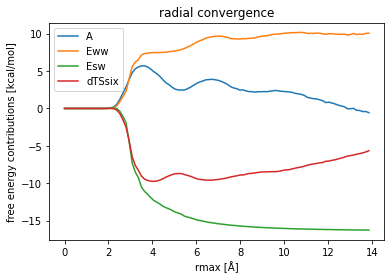

In [16]:
# Without an entropy reference, there is no good convergence of the entropy contribution.
for col in ['A', 'Eww', 'Esw', 'dTSsix']:
    bins, rdf = gistfile.rdf(col, rmax=14, bins=100)
    plt.plot(bins, np.cumsum(rdf), label=col)
plt.legend()
plt.gca().set(xlabel='rmax [Å]', ylabel='free energy contributions [kcal/mol]', title='radial convergence')
plt.show()

GIST free energy: 3.59
GIST free energy using entropy scaling: -0.36
FreeSolv free energy (TI, Gaff): -0.81


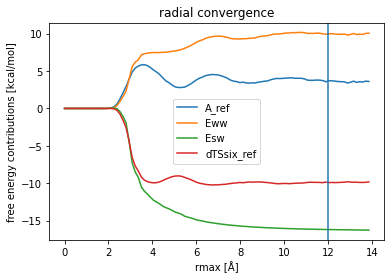

In [17]:
# By subtracting a reference entropy, the entropy contribution converges much better.

gistfile['dTSsix_ref_norm'] = gistfile['dTSsix_norm'] - refvals['dTSsix']
gistfile['dTSsix_ref_dens'] = gistfile.norm2dens(gistfile['dTSsix_ref_norm'])
gistfile['A_ref_dens'] = gistfile['Eall_dens'] - gistfile['dTSsix_ref_dens']

for col in ['A_ref', 'Eww', 'Esw', 'dTSsix_ref']:
    bins, rdf = gistfile.rdf(col, rmax=14, bins=100)
    plt.plot(bins, np.cumsum(rdf), label=col)
plt.legend()
plt.gca().set(xlabel='rmax [Å]', ylabel='free energy contributions [kcal/mol]', title='radial convergence')
plt.axvline(12)
e_integral = gistfile.integrate_around('Eall', 12)['Eall']
s_integral = gistfile.integrate_around('dTSsix_ref', 12)['dTSsix_ref']

print("GIST free energy: {:.2f}".format(e_integral - s_integral))
print("GIST free energy using entropy scaling: {:.2f}".format(e_integral - s_integral*0.6))
print("FreeSolv free energy (TI, Gaff): {:.2f}".format(-0.81))
plt.show()

### Integrating around a subset of the solute
To select only a part of the solute, the projection_nearest method should be used. Alternatively, one can also supply a subset of the molecular structure to `integrate_around`. However, this is **not** equivalent, since it includes parts of the solvent that are within `rmax` of the selected solute atoms, but even closer to others. If the selection does not form a large and well-defined patch, the difference can be massive.

In [18]:
selected_atoms = np.arange(6)
print(f'{len(selected_atoms)} atoms selected')
# Careful! The structure is an MDTraj trajectory object, which uses nm.
print("Manual selection:", gistfile.integrate_around(['A'], centers=gistfile.struct.xyz[0, selected_atoms, :] * 10., rmax=7.0)['A'])
print("projection_nearest:", gistfile.projection_nearest(['A'], rmax=7.0).loc[selected_atoms, 'A'].sum())

6 atoms selected
Manual selection: 3.689971618014245
projection_nearest: 1.9406242305928416


If the selection *does* form a large and well-defined patch, and if the radius is small, the difference is not so big

In [19]:
selected_atoms = np.arange(6)
print(f'{len(selected_atoms)} atoms selected')
# Careful! The structure is an MDTraj trajectory object, which uses nm.
print("Manual selection:", gistfile.integrate_around(['A'], centers=gistfile.struct.xyz[0, selected_atoms, :] * 10., rmax=3.0)['A'])
print("projection_nearest:", gistfile.projection_nearest(['A'], rmax=7.0).loc[selected_atoms, 'A'].sum())

6 atoms selected
Manual selection: 1.798777234350399
projection_nearest: 1.9406242305928416


## RDF functionality
Gisttools uses a slightly non-standard definition of rdf. Rather than computing an actual rdf (radial distribution function), it integrates the Gist columns in radial shells around the solute. This can be used to compute an actual rdf, but is more commonly applied to judge the convergence of GIST quantities with regards to the solute-solvent distance.

An actual Rdf is a histogram of the population in a certain distance to the center of the solute, normalized by the volume of the respective bin and the reference density. If the Gist object's normalization is correct, this can be obtained from the g_O column:

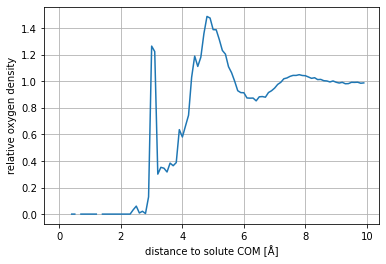

In [20]:
center = np.mean(gistfile.coord, axis=0)
bins, (go_rdf, vox_rdf) = gistfile.multiple_rdfs(['g_O', 'voxels'], centers=center, rmax=10, bins=100, col_suffix='')
plt.plot(bins, go_rdf / (vox_rdf * gistfile.grid.voxel_volume))
plt.gca().set(xlabel='distance to solute COM [Å]', ylabel='relative oxygen density')
plt.grid()

An Rdf with regard to the closest atom (rather than the molecular center) will have a nicer first hydration shell, since it takes the non-spherical nature of the solute into account:

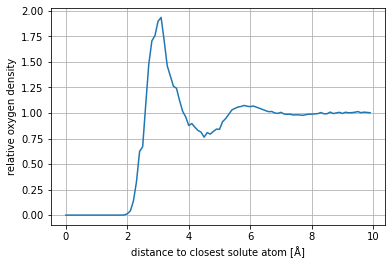

In [21]:
bins, (go_rdf, vox_rdf) = gistfile.multiple_rdfs(['g_O', 'voxels'], rmax=10, bins=100, col_suffix='')
plt.plot(bins, go_rdf / (vox_rdf * gistfile.grid.voxel_volume))
plt.gca().set(xlabel='distance to closest solute atom [Å]', ylabel='relative oxygen density')
plt.grid()

Similarly, an "Rdf" of the solvent-solvent energy around the molecule can be obtained, with regard to the closest center.

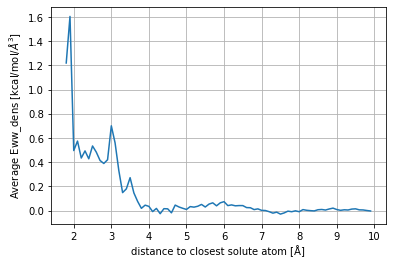

In [22]:
bins, (rdf, pop_rdf) = gistfile.multiple_rdfs(['Eww_dens', 'population'], rmax=10, bins=100, col_suffix='')
plt.plot(bins, rdf / (pop_rdf / (gistfile.n_frames * gistfile.grid.voxel_volume)))
plt.gca().set(xlabel='distance to closest solute atom [Å]', ylabel='Average Eww_dens [kcal/mol/$Å^3$]')
plt.grid()

The rdf output is normalized in such a way that computing the sum corresponds to an integral over the specified column. We can compute the cumulative sum to see how the integral of Eww changes with the distance cutoff.

[Text(0.5, 0, 'distance cutoff [Å]'), Text(0, 0.5, 'Eww integral [kcal/mol]')]

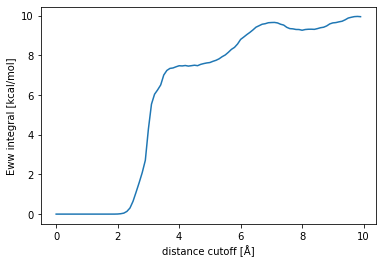

In [23]:
plt.plot(bins, np.cumsum(rdf))
plt.gca().set(xlabel='distance cutoff [Å]', ylabel='Eww integral [kcal/mol]')

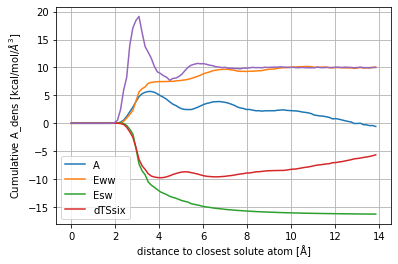

In [24]:
cols = ['A', 'Eww', 'Esw', 'dTSsix']
bins, rdfs = gistfile.multiple_rdfs(cols, rmax=14, bins=100)
for col, rdf in zip(cols, rdfs):
    plt.plot(bins, np.cumsum(rdf), label=col)
bins, (go_rdf, vox_rdf) = gistfile.multiple_rdfs(['g_O', 'voxels'], rmax=14, bins=100, col_suffix='')
plt.plot(bins, go_rdf / (vox_rdf * gistfile.grid.voxel_volume) * 10)
plt.plot()
plt.legend()
plt.gca().set(xlabel='distance to closest solute atom [Å]', ylabel='Cumulative A_dens [kcal/mol/$Å^3$]')
plt.grid()

## Distance weights

Several methods of Gist objects (`integrate_around`, `projection_nearest`, `projection_mean`) allow you to supply a distance weighting function. A few functional forms are predefined, but you can also specify callables. The predefined functions can be accessed via `gisttools.utils.distance_weight`.

In [25]:
from gisttools.utils import distance_weight

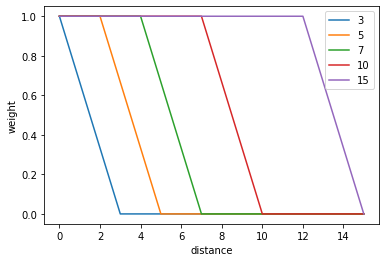

In [26]:
x = np.linspace(0, 15, 151)
test_radii = [3, 5, 7, 10, 15]
for radius in test_radii:
    plt.plot(
        x,
        distance_weight(x, method="piecewise_linear", constant=radius-3, cutoff=radius),
        label=radius
    )
plt.xlabel("distance")
plt.ylabel("weight")
plt.legend()

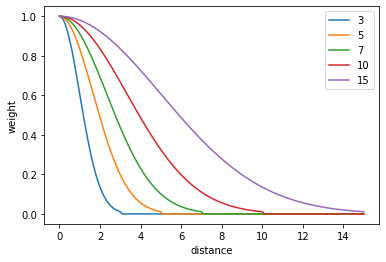

In [27]:
x = np.linspace(0, 15, 151)
test_radii = [3, 5, 7, 10, 15]
for radius in test_radii:
    weights = distance_weight(x, method="gaussian", sigma=radius/3)
    weights[x > radius] = 0
    plt.plot(x, weights, label=radius)
plt.xlabel("distance")
plt.ylabel("weight")
plt.legend()

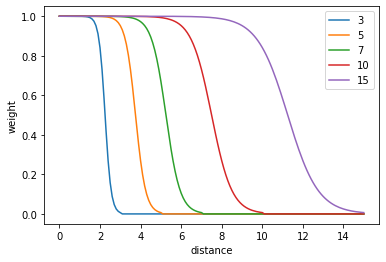

In [28]:
x = np.linspace(0, 15, 151)
test_radii = [3, 5, 7, 10, 15]
for radius in test_radii:
    weights = distance_weight(x, method="logistic", k=20/radius, x0=radius*0.75)
    weights[x > radius] = 0
    plt.plot(x, weights, label=radius)
plt.xlabel("distance")
plt.ylabel("weight")
plt.legend()

## Write OpenDX files

`gisttools` supports minimal `.dx` writing capabilities, enough to export single arrays for PyMOL or VMD.

In [29]:
with tempfile.TemporaryDirectory() as tmpdir:
    fname = os.path.join(tmpdir, 'A_dens_test.dx')
    gistfile.save_dx('A_dens', fname)
    with open(fname) as f:
        for l in f.readlines(300):
            print(l, end='')

object 1 class gridpositions counts 81 81 81
origin -20.0 -20.0 -20.0
delta 0.5 0 0
delta 0 0.5 0
delta 0 0 0.5
object 2 class gridconnections counts 81 81 81
object 3 class array type double rank 0 items 531441 data follows
0.003220
0.008456
0.014216
0.005524
-0.001372
-0.011889
0.002042
-0.012511
-0.010014


## Off-label use-cases of the Grid class
The Grid class can be handy in situations that are not related to GIST. E.g., it can be combined with scikit-image to create a triangulated solvent-accessible surface.

In [30]:
from skimage.measure import marching_cubes
from scipy.interpolate import interpn
import ipyvolume as ipv

Define element colors:

In [31]:
elem_colors = np.zeros((20, 3), dtype=float) # all black, no elements over 20
elem_colors[1] = [.7, .7, .7] # hydrogen light gray
elem_colors[6] = [.3, .3, .3] # carbon dark gray
elem_colors[7] = [0, .2, 1] # nitrogen blue
elem_colors[8] = [1, 0, 0] # oxygen red

Using the Gist class: 

In [32]:
SOLVENT_RADIUS = 1.4

solute_distance = np.full(gistfile.grid.shape, np.inf)
closest_atom = np.zeros(gistfile.grid.shape, dtype=int)
ii, atoms, dd = gistfile.distance_to_spheres(rmax=4, atomic_radii='struct')
solute_distance.ravel()[ii] = dd
closest_atom.ravel()[ii] = atoms

verts, faces, normals, values = marching_cubes(solute_distance, level=SOLVENT_RADIUS, spacing=gistfile.grid.delta, gradient_direction='ascent')
verts += gistfile.grid.origin
elements = np.array([a.element.number for a in gistfile.struct.top.atoms])
colors = interpn(gistfile.grid.edges, elem_colors[elements[closest_atom]], verts)

In [33]:
ipv.figure()
ipv.plot_trisurf(*verts.T, triangles=faces, color=colors)
ipv.xyzlim(-4, 4)
ipv.show()

Using the Grid class gives more control, e.g., the Grid spacing can be fine-tuned. Depending on the grid size, this can be RAM-intensive...

In [34]:
SOLVENT_RADIUS = 1.4
grid = gt.grid.Grid.centered([0, 0, 0], 160, .1)
coords = gistfile.coord # already in Angstrom
radii = np.array([a.element.radius for a in gistfile.struct.top.atoms]) * 10.

solute_distance = np.full(grid.shape, np.inf)
closest_atom = np.zeros(grid.shape, dtype=int)
ii, atoms, dd = grid.distance_to_spheres(coords, rmax=4, radii=radii)
solute_distance.ravel()[ii] = dd
closest_atom.ravel()[ii] = atoms

verts, faces, normals, values = marching_cubes(solute_distance, level=SOLVENT_RADIUS, spacing=grid.delta, gradient_direction='ascent')
verts += grid.origin
elements = np.array([a.element.number for a in gistfile.struct.top.atoms])
colors = interpn(grid.edges, elem_colors[elements[closest_atom]], verts)

In [35]:
ipv.figure()
ipv.plot_trisurf(*verts.T, triangles=faces, color=colors)
origin = grid.origin - grid.delta / 2
end = grid.xyzmax + grid.delta / 2
ipv.xlim(origin[0], end[0])
ipv.ylim(origin[1], end[1])
ipv.zlim(origin[2], end[2])
ipv.show()

Solvent-excluded surfaces (like those in PyMOL or VMD) can be done in a 2-step procedure. However, this is not very efficient, and there are artefacts when the molecule touches the grid boundary.

In [36]:
SOLVENT_RADIUS = 1.4
grid = gt.grid.Grid.centered([0, 0, 0], 160, .1)
coords = gistfile.coord # already in Angstrom
radii = np.array([a.element.radius for a in gistfile.struct.top.atoms]) * 10.

accessible_distance = np.full(grid.shape, np.inf)
ii, _, dd = grid.distance_to_spheres(coords, rmax=4, radii=radii)
accessible_distance.ravel()[ii] = dd
accessible_verts, _, _, _ = marching_cubes(accessible_distance, level=SOLVENT_RADIUS, spacing=grid.delta, gradient_direction='ascent')
accessible_verts += grid.origin
outside = accessible_distance > 2

excluded_distance = np.full(grid.shape, np.inf)
ii, _, dd = grid.distance_to_centers(accessible_verts, rmax=2)
excluded_distance.ravel()[ii] = dd
excluded_distance[outside] = -10

verts, faces, normals, values = marching_cubes(excluded_distance, level=SOLVENT_RADIUS, spacing=grid.delta, gradient_direction='descent')
verts += grid.origin
elements = np.array([a.element.number for a in gistfile.struct.top.atoms])
colors = interpn(grid.edges, elem_colors[elements[closest_atom]], verts)

In [37]:
ipv.figure()
ipv.plot_trisurf(*verts.T, triangles=faces, color=colors)
origin = grid.origin - grid.delta / 2
end = grid.xyzmax + grid.delta / 2
ipv.xlim(origin[0], end[0])
ipv.ylim(origin[1], end[1])
ipv.zlim(origin[2], end[2])
ipv.show()